# Tutorial for UOTReg on the Embryoid dataset

- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

In [ ]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load UOTReg functions
## functions for Robust Local Frechet Reg
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new
## functions of learning OT/UOT maps
from UOTReg.UOT import UOT_relax_on_2


# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap
import seaborn as sns

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Setup data

In [ ]:
import scanpy as sc

# path to the dataset
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
e_path = result_folder + "data/timedata/embryoid/"

# Note: this is the top 1000 HVGs of embryoid dataset, already normalized to 1e4 and log1p transformed
embryoid = sc.read(e_path + "embryoid_data.h5ad")
print(embryoid.shape)

(16821, 1000)


### Basic preprocessing of the dataset

In [4]:
# Convert PCA array to Pandas data frame
embryoid_pc = embryoid.obsm['X_pca'][:,0:20]

embryoid_pc_df = pd.DataFrame(
    data=embryoid_pc,
    index=embryoid.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(embryoid_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(embryoid_pc_df))  # Should be <class 'pandas.DataFrame'>
print(embryoid_pc_df.shape)

# get the time snapshots info
cells_meta = embryoid.obs
unique_time = embryoid.obs['time'].unique().to_list()
print(unique_time)

<class 'pandas.core.frame.DataFrame'>
(16821, 20)
['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']


In [5]:
# samplers are for further training usage
Y_time_samplers = []

for id in unique_time:
    X_k = embryoid_pc_df[embryoid.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

2381
4165
3278
3665
3332


<Figure size 600x200 with 0 Axes>

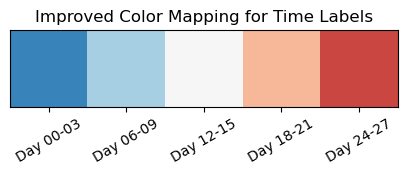

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color gradient with higher contrast
color_palette = sns.color_palette("RdBu_r", n_colors=5)  # Using reversed Red-Blue colormap

# Assign colors to time labels
time_labels = ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']
color_dict = dict(zip(time_labels, color_palette))

# Show the new color mapping
plt.figure(figsize=(6, 2))
sns.palplot(color_palette)
plt.xticks(range(5), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()

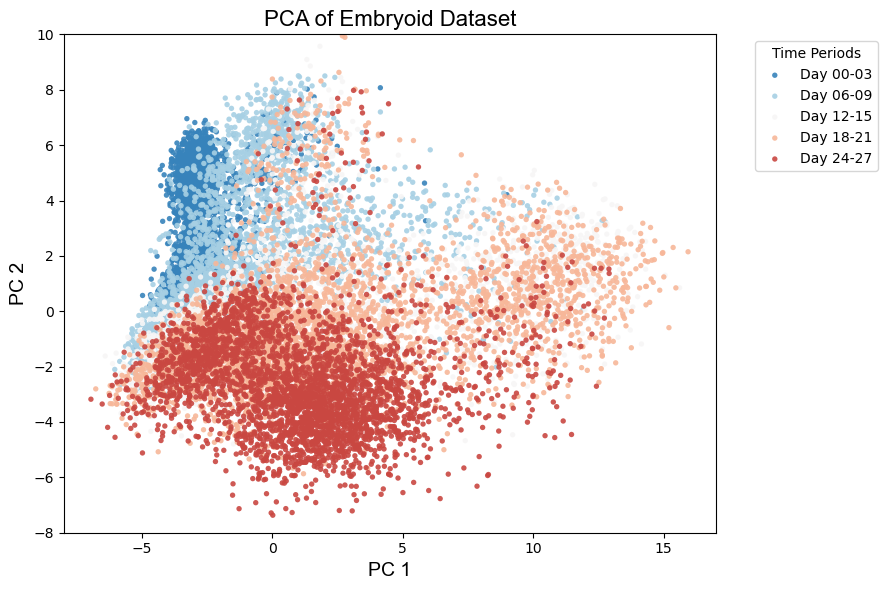

In [7]:
# Extract the first two principal components
pc1 = embryoid.obsm['X_pca'][:, 0]
pc2 = embryoid.obsm['X_pca'][:, 1]

# Customizable parameters
alpha_values = {
    'Day 00-03': 0.9,
    'Day 06-09': 0.9,
    'Day 12-15': 0.9,
    'Day 18-21': 0.9,
    'Day 24-27': 0.9
}
marker_size = 15  # Adjust scatter size
font_family = "Arial"  # Change font family
font_size_label = 14   # Font size for axis labels
font_size_title = 16   # Font size for title

# Allow custom axis limits (change as needed)
x_range = (-8, 17)
y_range = (-8, 10)

plt.figure(figsize=(9, 6))

# Plot each time group with no edge color, ensuring points are fully filled
for label in time_labels:
    subset = embryoid.obs['time'] == label
    plt.scatter(
        pc1[subset], 
        pc2[subset], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_size,  # Adjustable marker size
        alpha=alpha_values[label], 
        edgecolors='none'  # Ensure no border for scatter points
    )

# Move the legend outside the plot
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Customize font styles
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset", fontsize=font_size_title, fontfamily=font_family)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


## UOTReg workflow

### Step 1: Robust Local Fréchet Regression

#### Calculate weight for Robust Local Frechet

- `timelist` represents the observed time points, while `predict_time` specifies the time at which you want to estimate the distribution.

In [8]:
timelist = [1.5, 7.5, 13.5, 19.5, 25.5]
## This is the timepoint which you want to estimate the distribution!
predict_time = 19.5

X = timelist.copy()
X = np.array(X)

## Local Frechet coefficient
# Bandwidth selection - Silverman's rule of thumb for Gaussian kernel
std_dev = np.std(X)
# h = 1.06 * std_dev * len(X) ** (-1/5)
h = 4

# Calculate moments
mu_0 = calculate_moments(X, predict_time, h, 0)
mu_1 = calculate_moments(X, predict_time, h, 1)
mu_2 = calculate_moments(X, predict_time, h, 2)

# Calculate empirical weights
ALPHAS_LF = calculate_weights(X, predict_time, h, mu_0, mu_1, mu_2)
K_time = len(ALPHAS_LF)
CLASSES_time = [i for i in range(K_time)]

print("mu_0:", mu_0)
print("mu_1:", mu_1)
print("mu_2:", mu_2)
print("Empirical weights s_in(x, h):", ALPHAS_LF)

mu_0: 0.033121265194313056
mu_1: -0.0026734944141590168
mu_2: 0.49843158956909583
Empirical weights s_in(x, h): [np.float64(2.180893027058777e-05), np.float64(0.0062624195220901445), np.float64(0.18930985818820406), np.float64(0.6025057893362391), np.float64(0.20190012402319613)]


In [9]:
# setup samplers for the leave-one-out experiment
Ysamplers = Y_time_samplers.copy()
for i in Ysamplers:
    print(i.length())

2381
4165
3278
3665
3332


#### Basic model setup

In [10]:
# hyperparameters 
DIM = embryoid_pc.shape[1]
NUM = K_time
device = "cpu"
bn = False

BATCH_SIZE = 64
G_ITERS, D_ITERS, T_ITERS = 50, 50, 10
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Parameters for T and D
input_size = DIM # DIM
n_outputs = NUM # number of distributions
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05

# paramerters for G
size=256
input_dim = DIM
num_layers = 4

- `D` is a neural network (NN) that parametrizes the potential function, while `T` is a neural network (NN) that parametrizes the transportation plan.

In [11]:
D = Seperate_D(input_size, task_specific_hidden_size_D, n_hidden, n_outputs, bn, dropout_rate)
D.apply(weights_init)
print(D)

# Seperate T
T = Seperate_T(input_size, task_specific_hidden_size_T, n_hidden, n_outputs, output_size, bn, dropout_rate)
T.apply(weights_init)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))

criterions = [nn.MSELoss() for _ in range(n_outputs)]
T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

print(n_outputs)

Seperate_D(
  (task_nets): ModuleList(
    (0-4): 5 x FFNN(
      (hidden): ModuleList(
        (0): Linear(in_features=20, out_features=256, bias=True)
        (1-4): 4 x Linear(in_features=256, out_features=256, bias=True)
        (5): Linear(in_features=256, out_features=1, bias=True)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
)
T params: 1368420
D params: 1344005
5


- `G` is a neural network (NN) that parametrizes the distribution, mapping a latent vector to the expected distribution.

In [12]:
# For now DIM_Z = DIM_X
Z_sampler = distributions.StandardNormalSampler(dim=input_dim, device=device)

G = Gnet(input_dim=input_dim, output_dim=DIM, size=size, num_layers=num_layers, dropout_rate=dropout_rate)

- You can initialize `G` using the code below or load a pretrained `G` that mimics the distribution of all data. Both approaches yield comparable results on the Embryoid dataset.

In [13]:
# # Initialization

# G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
# loss = np.inf

# G.train(True)

# for iteration in tqdm(range(10000)):
#     Z = Z_sampler.sample(BATCH_SIZE).detach() * 6
#     loss = F.mse_loss(Z, G(Z))
#     loss.backward()
#     G_opt.step(); G_opt.zero_grad()
#     if loss.item() < 1e-2:
#         break

# # Pretrained results

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
G.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/G_embryoid20_256_Day4_ini.pth"))

<All keys matched successfully>

In [14]:
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)

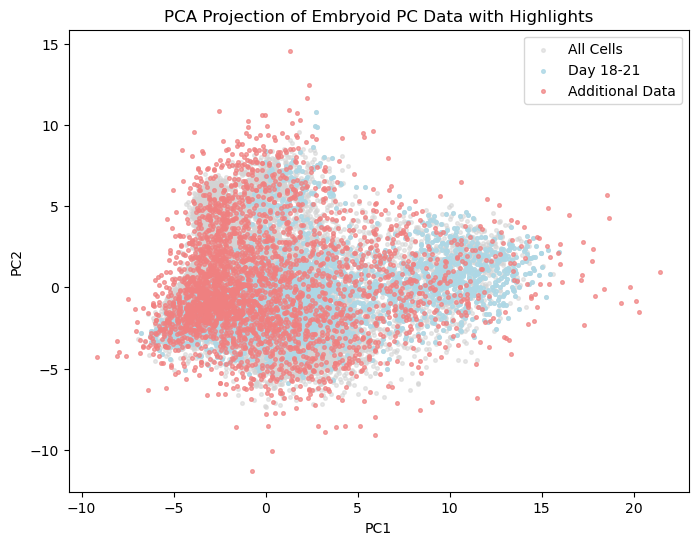

In [15]:
# visualize current barycenter - pca

# Step 1: Plot using first two PCs of `embryoid_pc_df`
plt.figure(figsize=(8, 6))

# Plot all cells in light grey
plt.scatter(
    embryoid_pc_df.iloc[:, 0], embryoid_pc_df.iloc[:, 1],
    color="lightgrey", label="All Cells", alpha=0.5, s=7
)

# Emphasize specific groups in light blue and light red
highlight_colors = {"Day 18-21": "lightblue"}
# highlight_colors = {"Day 12-15": "lightblue", "Day 06-09": "yellow", "Day 18-21": "purple"}
group_labels = embryoid.obs['time']  # Assuming `time` column exists with group labels

for group, color in highlight_colors.items():
    mask = group_labels == group
    plt.scatter(
        embryoid_pc_df.iloc[mask.to_numpy(), 0], embryoid_pc_df.iloc[mask.to_numpy(), 1],
        color=color, label=group, alpha=0.8, s=7
    )

# Step 4: plot additional data in dark grey
X_np = G(Z_sampler.sample(3000)).detach().numpy()
plt.scatter(
    X_np[:, 0], X_np[:, 1],
    color="lightcoral", label="Additional Data", alpha=0.7, s=7
)

# Finalizing the plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA Projection of Embryoid PC Data with Highlights")
plt.show()

In [16]:
G_loss_history = []

#### Estimating the distribution (training `T`, `D`, and `G`) using Robust Local Fréchet Regression

- `optimize_T_and_D_UOT_new` enables tuning of the tolerance level `tau` for unbalanced OT, where a larger `tau` indicates greater tolerance for mismatch in the target distribution.
- `optimize_T_and_D` is the counterpart for traditional Optimal Transport (Local Fréchet Regression).

Iteration 2100


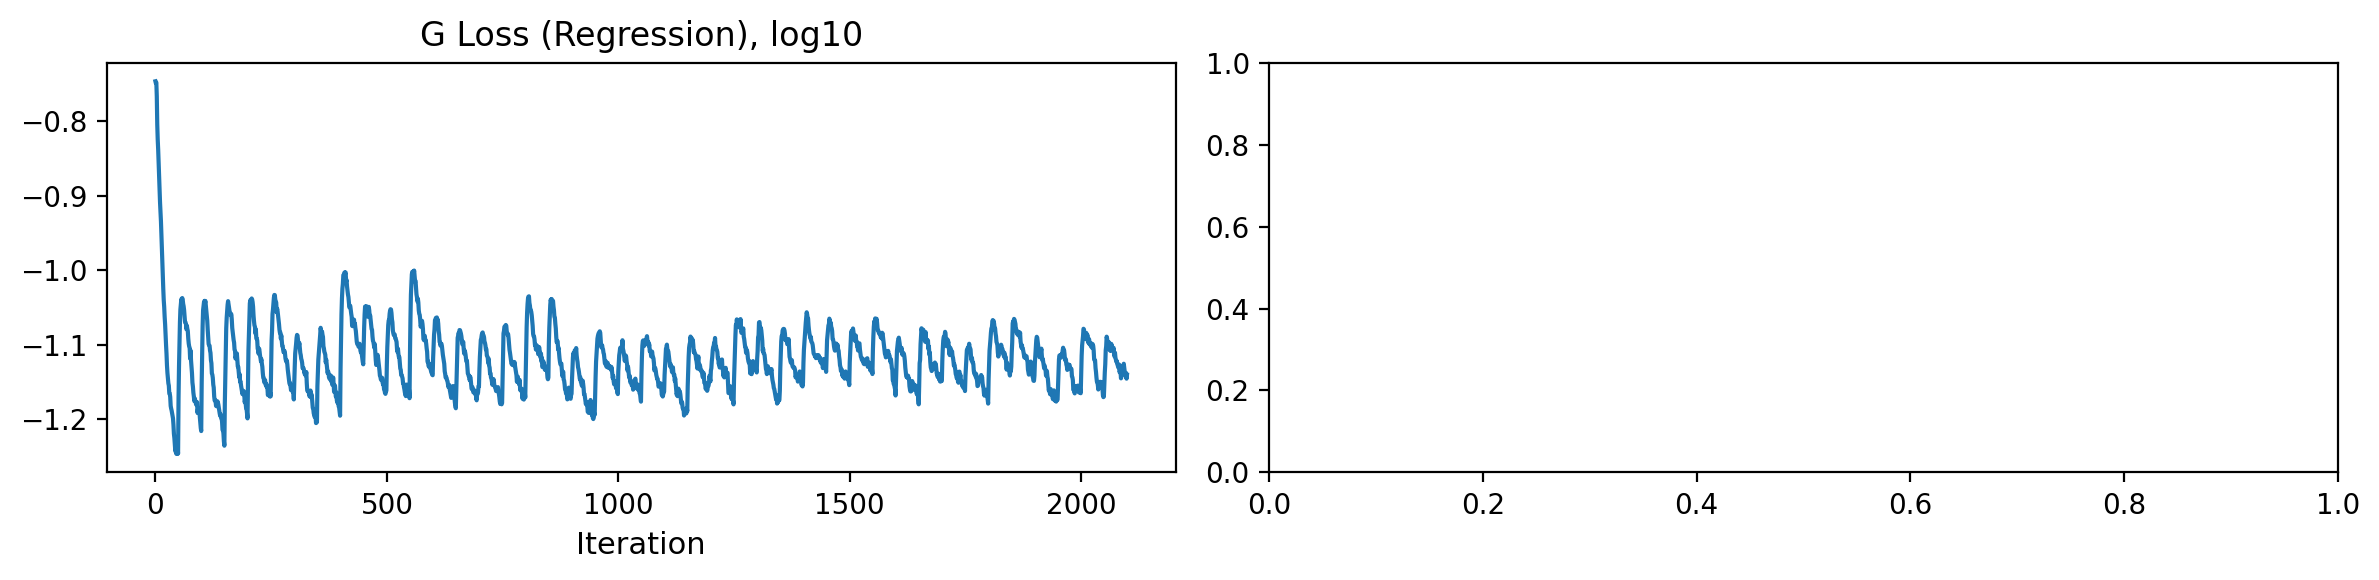

plt!!!!!!!!


In [ ]:
# some parameters
MAX_ITER = 200000

# joint training T, then train the network distributedly
BATCH_SIZE = 64
BATCH_SIZE_G = 128

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

# Main Training Loop
it = 0 # number of iterations
G_time = 0 # numbers of G updating
loss_at_start = 0
start_losses = [] # a list of the first G_losses after updating T

while it < MAX_ITER:

    G_time += 1
    
    # Optimize T and D
    # it = optimize_T_and_D(it, G, T, D, T_opt, D_opt, Z_sampler, Ysamplers, NUM, DIM, BATCH_SIZE, ALPHAS_LF, D_ITERS, T_ITERS)
    it = optimize_T_and_D_UOT_new(it, G, T, D, T_opt, D_opt, Z_sampler, Ysamplers, NUM, DIM, BATCH_SIZE, ALPHAS_LF, D_ITERS, T_ITERS, tau=5)

    loss_at_start = optimize_G(G, T, G_opt, Z_sampler, ALPHAS_LF, NUM, DIM, G_ITERS, BATCH_SIZE_G, G_loss_history)
    start_losses.append(loss_at_start)

    # Plot metrics
    # Plotting
    if True:
        clear_output(wait=True)
        print('Iteration', it)

        # Plotting Metrics
        fig, axes = plt.subplots(1, figsize=(7, 3), dpi=200)

        axes[0].set_title('G Loss (Regression), log10', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(np.log10(ewma(G_loss_history, span=10)))

        fig.tight_layout(); plt.show(); plt.close(fig)

        print("plt!!!!!!!!")

    # Early stopping or checkpoint saving
    if G_time > 41:
        break

- After training, you can save the learned distribution `G` to your specified directory.
- To save time, we also provide trained networks to proceed with the subsequent steps.

In [ ]:
# # This is revision, new estimation saving
# save_path = "Path/to/your/folder"
# torch.save(G.state_dict(), save_path+"/G_embryoid20_256_Day19_25_tau5_new2.pth")

- Some visualizations

In [17]:
# loading the learned generators
size = 256
DIM = 20
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G4 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G5 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G6 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G7 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G2.parameters()]))


###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 

G1.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day4_25_tau5_new2.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day7_25_tau5_new2.pth"))
G3.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day10_25_tau5_new2.pth"))
G4.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day13_25_tau5_new2.pth"))
G5.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day16_25_tau5_new2.pth"))
G6.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day19_25_tau5_new2.pth"))
G7.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day22_25_tau5_new2.pth"))

G params: 207892


<All keys matched successfully>

In [18]:
# check learned distributions

G1.eval(); G2.eval(); G3.eval(); G4.eval(); G5.eval(); G6.eval(); G7.eval()
data_num = 2000
data_learned1 = G1(Z_sampler.sample(data_num)).detach().numpy()
data_learned2 = G2(Z_sampler.sample(data_num)).detach().numpy()
data_learned3 = G3(Z_sampler.sample(data_num)).detach().numpy()
data_learned4 = G4(Z_sampler.sample(data_num)).detach().numpy()
data_learned5 = G5(Z_sampler.sample(data_num)).detach().numpy()
data_learned6 = G6(Z_sampler.sample(data_num)).detach().numpy()
data_learned7 = G7(Z_sampler.sample(data_num)).detach().numpy()

# Combine original and new time labels in chronological order
time_labels = [
    'Day 00-03', 'Day 03-06 (predicted)', 'Day 06-09 (predicted)', 'Day 09-12 (predicted)', 
    'Day 12-15 (predicted)', 'Day 15-18 (predicted)', 'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27'
]

# Define data sources accordingly (assuming you already have the data)
data_dict_ori = {
    'Day 00-03': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 00-03'],
    'Day 06-09': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 06-09'],
    'Day 12-15': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 12-15'],
    'Day 18-21': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 18-21'],
    'Day 24-27': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 24-27']
}

data_dict = {
    'Day 00-03': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 00-03'],
    'Day 03-06 (predicted)': data_learned1,
    'Day 06-09 (predicted)': data_learned2,
    'Day 09-12 (predicted)': data_learned3,
    'Day 12-15 (predicted)': data_learned4,
    'Day 15-18 (predicted)': data_learned5,
    'Day 18-21 (predicted)': data_learned6,
    'Day 21-24 (predicted)': data_learned7,
    'Day 24-27': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 24-27']
}

<Figure size 800x200 with 0 Axes>

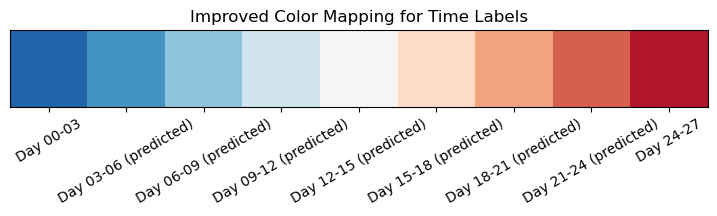

In [19]:
# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=9)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Show the updated color mapping
plt.figure(figsize=(8, 2))
sns.palplot(color_palette)
plt.xticks(range(9), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()


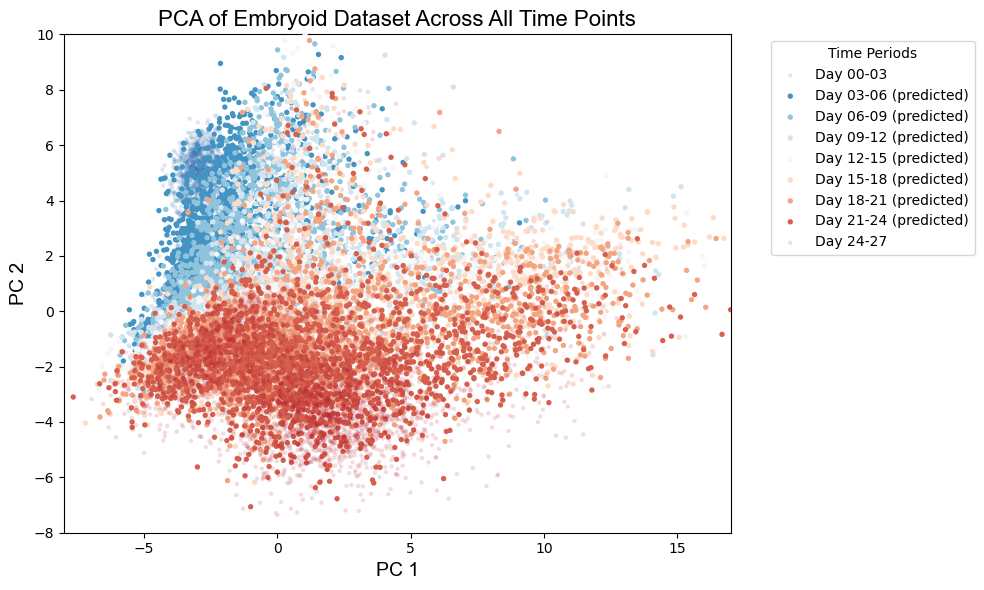

In [20]:
# Define visualization parameters
marker_size = 15  # Adjust marker size
font_family = "Arial"  # Customize font
font_size_label = 14  # Axis labels font size
font_size_title = 16  # Title font size
alpha_values = 1  # General transparency setting

# Scatter plot with the combined datasets
x_range = (-8, 17)
y_range = (-8, 10)

plt.figure(figsize=(10, 6))

z_orders = {
    'Day 00-03': 1,
    'Day 06-09 (predicted)': 7,
    'Day 12-15 (predicted)': 9,
    'Day 18-21 (predicted)': 11,
    'Day 24-27': 17,
    'Day 03-06 (predicted)': 6,
    'Day 09-12 (predicted)': 8,
    'Day 15-18 (predicted)': 10,
    'Day 21-24 (predicted)': 12
}

marker_sizes = {
    'Day 00-03': 10,
    'Day 06-09 (predicted)': 15,
    'Day 12-15 (predicted)': 15,
    'Day 18-21 (predicted)': 15,
    'Day 24-27': 10,
    'Day 03-06 (predicted)': 15,
    'Day 09-12 (predicted)': 15,
    'Day 15-18 (predicted)': 15,
    'Day 21-24 (predicted)': 15
}

alpha_values = {
    'Day 00-03': 0.15,
    'Day 06-09 (predicted)': 1,
    'Day 12-15 (predicted)': 1,
    'Day 18-21 (predicted)': 1,
    'Day 24-27': 0.15,
    'Day 03-06 (predicted)': 1,
    'Day 09-12 (predicted)': 1,
    'Day 15-18 (predicted)': 1,
    'Day 21-24 (predicted)': 1
}

for label in time_labels:
    data = data_dict[label]
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  # Scatter point size
        alpha=alpha_values[label], 
        edgecolors='none',  # Ensure fully filled points
        zorder = z_orders[label]
    )

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset Across All Time Points", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
plt.legend(title="Time Periods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


### Step 2: Composing OT/UOT maps between estimated distributions

#### Construct new samplers

In [21]:
import pandas as pd
import torch

torch.manual_seed(0)

day_labels = [4, 7, 10, 13, 16, 19, 22]
generators = [G1, G2, G3, G4, G5, G6, G7]
n_per_day  = 5000
DIM        = Z_sampler.dim if hasattr(Z_sampler, "dim") else 20   # keep DIM consistent
device     = torch.device("cpu")

# Choose column names for the DataFrame
try:
    X_cols = list(embryoid_pc_df.columns)[:DIM]
    if len(X_cols) != DIM:
        raise ValueError("embryoid_pc_df has incompatible number of columns.")
except Exception:
    X_cols = [f"pc{i+1}" for i in range(DIM)]

for G in generators:
    G.eval()

Y_time_samplers_learned = []
for day, G in zip(day_labels, generators):
    with torch.no_grad():
        Z_t   = Z_sampler.sample(n_per_day)                   # torch [n, DIM]
        X_t   = G(Z_t).detach().to(device).float()            # torch [n, DIM]
        X_np  = X_t.cpu().numpy()                             # numpy [n, DIM]
        X_k   = pd.DataFrame(X_np, columns=X_cols)            # <-- pandas DataFrame

    cells_k = pd.DataFrame({
        "cell_id": [f"d{day}_{i}" for i in range(n_per_day)],
        "time":    day,
        "day":     day
    })

    dataset_k = tensorDataset(X_k, cells_k)
    sampler_k = tensorSampler(dataset_k, device="cpu")
    Y_time_samplers_learned.append(sampler_k)

    print(f"Day {day}: dataset size = {len(dataset_k)}, X_k shape = {X_k.shape}, columns = {X_k.columns[:3].tolist()}...")


Day 4: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 7: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 10: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 13: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 16: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 19: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 22: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...


In [22]:
Y_time_samplers_mix = [Y_time_samplers[0], *Y_time_samplers_learned, Y_time_samplers[-1]]

#### Estimating the UOT maps between t to t+1.

- You can run the subsequent code to train and save the learned distribution `G` to your specified directory.
- To save time, we also provide trained networks to proceed with the visualization.

In [ ]:
import torch
import os
import pickle

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Define hyperparameters
it = 0
BATCH_SIZE = 128
D_ITERS = 300
T_ITERS = 100
save_path = "Path/to/your/folder"

# Ensure save directory exists
os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(8):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)
    
    # Apply weight initialization
    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path + f"/reg50/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/reg50/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    # it = OT(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS)
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=50)

    map_filename_T = os.path.join(save_path, f"reg50/T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"reg50/D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i+1} to {i+2} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")


#### Visualizations

<Figure size 800x200 with 0 Axes>

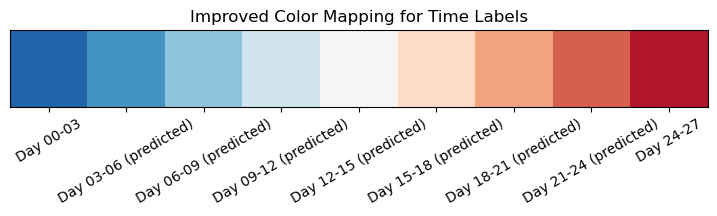

In [23]:
time_labels = [
    'Day 00-03', 'Day 03-06 (predicted)', 'Day 06-09 (predicted)', 'Day 09-12 (predicted)', 
    'Day 12-15 (predicted)', 'Day 15-18 (predicted)', 'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27'
]

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=9)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Show the updated color mapping
plt.figure(figsize=(8, 2))
sns.palplot(color_palette)
plt.xticks(range(9), time_labels, rotation=30)
plt.title("Improved Color Mapping for Time Labels")
plt.show()


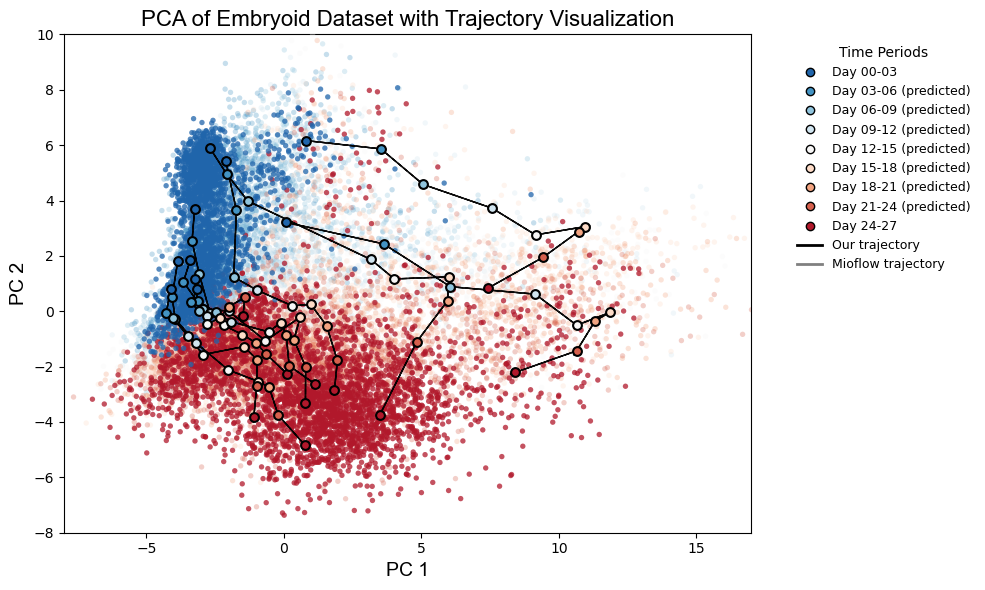

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Generate a higher contrast and saturation color gradient
color_palette = sns.color_palette("RdBu_r", n_colors=9)

# Assign colors to each time label
color_dict = dict(zip(time_labels, color_palette))

# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/reg50/T_map_{i+1}_to_{i+2}.pt") for i in range(8)]

# Sample 10 points from Ysamplers_new[0]
num_points = 10
data = Y_time_samplers_mix[0].sample(1000)
indices = np.random.choice(data.shape[0], num_points, replace=False)
data_selected = data[indices]

# Convert data to numpy for visualization
trajectory = [data_selected.detach().numpy()]
trajectory_time_labels = ['Day 00-03','Day 03-06 (predicted)','Day 06-09 (predicted)','Day 09-12 (predicted)','Day 12-15 (predicted)','Day 15-18 (predicted)',
                'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27']
trajectory_colors = plt.cm.viridis(np.linspace(0, 1, 10))

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data_selected.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)  # Shape: (9, num_points, feature_dim)
traj_reg = trajectory

# Define visualization parameters
marker_size = 15
font_family = "Arial"
font_size_label = 14
font_size_title = 16

x_range = (-8, 17)
y_range = (-8, 10)

z_orders = {
    'Day 00-03': 10,
    'Day 06-09 (predicted)': 2,
    'Day 12-15 (predicted)': 4,
    'Day 18-21 (predicted)': 6,
    'Day 24-27': 9,
    'Day 03-06 (predicted)': 1,
    'Day 09-12 (predicted)': 3,
    'Day 15-18 (predicted)': 5,
    'Day 21-24 (predicted)': 7
}

marker_sizes = {
    'Day 00-03': 15,
    'Day 06-09 (predicted)': 15,
    'Day 12-15 (predicted)': 15,
    'Day 18-21 (predicted)': 15,
    'Day 24-27': 15,
    'Day 03-06 (predicted)': 15,
    'Day 09-12 (predicted)': 15,
    'Day 15-18 (predicted)': 15,
    'Day 21-24 (predicted)': 15
}

alpha_values = {
    'Day 00-03': 0.75,
    'Day 06-09 (predicted)': 0.3,
    'Day 12-15 (predicted)': 0.3,
    'Day 18-21 (predicted)': 0.3,
    'Day 24-27': 0.75,
    'Day 03-06 (predicted)': 0.3,
    'Day 09-12 (predicted)': 0.3,
    'Day 15-18 (predicted)': 0.3,
    'Day 21-24 (predicted)': 0.3
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original dataset with different colors
for label in time_labels:
    data = data_dict[label]
    plt.scatter(
        data[:, 0], data[:, 1], 
        c=[color_dict[label]], 
        label=label, 
        s=marker_sizes[label],  
        alpha=alpha_values[label], 
        edgecolors='none',
        zorder=z_orders[label]
    )
    
# Plot sampled points and their trajectories with higher z-order 
for i in range(current_data.shape[0]):
    traj_color = "black"

    for j in range(len(trajectory) - 1):
        # Plot line segments between consecutive steps
        plt.plot([trajectory[j, i, 0], trajectory[j + 1, i, 0]], 
                 [trajectory[j, i, 1], trajectory[j + 1, i, 1]], 
                 linestyle='--', color=traj_color, linewidth=1, alpha=0.8, zorder=10)  # Higher z-order for lines

        # Add arrow to indicate direction
        plt.arrow(trajectory[j, i, 0], trajectory[j, i, 1],
                  trajectory[j + 1, i, 0] - trajectory[j, i, 0],
                  trajectory[j + 1, i, 1] - trajectory[j, i, 1],
                  color=traj_color, alpha=0.9, head_width=0.1, head_length=0.2, zorder=11)

        # Add intermediate points with corresponding color and black border
        step_label = trajectory_time_labels[j]  # Get the corresponding time label
        plt.scatter(trajectory[j, i, 0], trajectory[j, i, 1], 
                    color=[color_dict[step_label]],  # Assign color based on time point
                    s=40, edgecolors='black', linewidth=1.5, zorder=12)

    # Plot the last point in the trajectory with its corresponding color
    plt.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1], 
                color=[color_dict[trajectory_time_labels[-1]]],  
                s=40, edgecolors='black', linewidth=1.5, zorder=12)

# Customize plot labels and title
plt.xlabel("PC 1", fontsize=font_size_label, fontfamily=font_family)
plt.ylabel("PC 2", fontsize=font_size_label, fontfamily=font_family)
plt.title("PCA of Embryoid Dataset with Trajectory Visualization", fontsize=font_size_title, fontfamily=font_family)

# Move the legend outside the plot
# Custom legend elements using Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 00-03'], markersize=6, label='Day 00-03'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 03-06 (predicted)'], markersize=6, label='Day 03-06 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 06-09 (predicted)'], markersize=6, label='Day 06-09 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 09-12 (predicted)'], markersize=6, label='Day 09-12 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 12-15 (predicted)'], markersize=6, label='Day 12-15 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 15-18 (predicted)'], markersize=6, label='Day 15-18 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 18-21 (predicted)'], markersize=6, label='Day 18-21 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 21-24 (predicted)'], markersize=6, label='Day 21-24 (predicted)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=color_dict['Day 24-27'], markersize=6, label='Day 24-27'),
    Line2D([0], [0], color='black', linewidth=2, label='Our trajectory'),
    Line2D([0], [0], color='gray', linewidth=2, label='Mioflow trajectory')
]

# Add custom legend outside the plot
plt.legend(
    handles=legend_elements, 
    title="Time Periods", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    frameon=False,
    fontsize=9
)

# Set axis limits
plt.xlim(x_range)
plt.ylim(y_range)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()